In [1]:
using DifferentialEquations, DelimitedFiles, Plots, DataFrames, CSV, ProgressMeter

In [189]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273


In [2]:
batchNum = 5
fileNum = 1
tspan = (0.0,10.0)  
udt = 0.00390625
tol = 1e-11

inputString = "/nBodyData/inputs/indat_$(batchNum)_$(fileNum).dat"
outputString = "/nBodyData/julSim/julia_batch$(batchNum)_$(fileNum).csv"
inA = readdlm(inputString, ',', Float64, '\n')
numLines = countlines(inputString)

50

In [3]:
iE = 2

# ex: 1109000002560 -> step 2560 of event 900000 of file 1 of batch 1
globalID = 1e9*batchNum + 1e8*fileNum + 1e4*iE
m1, m2, m3 = inA[iE,1], inA[iE,8], inA[iE,15]
g = 1 # G not g 

#       x1,         x2,       x3,         y1,         y2,        y3,         vx1,     vx2,       vx3,            vy1,       vy2,      vy3
p0 = [inA[iE,2], inA[iE,9], inA[iE,16], inA[iE,3], inA[iE,10], inA[iE,17], inA[iE,5], inA[iE,12], inA[iE,19], inA[iE,6], inA[iE,13], inA[iE,20]]
iEnergy = -(2*(m1*m3)/((((p0[1]-p0[3])^2)+ ((p0[4]-p0[6])^2))^0.5)) - (2*(m2*m3)/((((p0[2]-p0[3])^2)+ ((p0[5]-p0[6])^2))^0.5)) - (2*(m1*m2)/((((p0[1]-p0[2])^2)+ ((p0[4]-p0[5])^2))^0.5))

iBaryX = (m1*p0[1]  + m2*p0[2]  + m3*p0[3])/(m1+m2+m3)
iBaryY = (m1*p0[4]  + m2*p0[5]  + m3*p0[6])/(m1+m2+m3)

-0.19598173611828873

In [6]:
function mass_system(du,u,p,t)
    x1,x2,x3,y1,y2,y3,dx1,dx2,dx3,dy1,dy2,dy3 = u

    du[1] = dx1
    du[2] = dx2
    du[3] = dx3
    du[4] = dy1
    du[5] = dy2
    du[6] = dy3

    du[7] = ((m2*(x2 - x1))/((x1 - x2)^2 + (y2 - y1)^2 )^(3/2)) + ((m3*(x3 - x1))/((x1 - x3)^2 + (y1 - y3)^2 )^(3/2))
    du[8] = ((m1*(x1 - x2))/((x1 - x2)^2 + (y1 - y2)^2 )^(3/2)) + ((m3*(x3 - x2))/((x2 - x3)^2 + (y2 - y3)^2 )^(3/2))
    du[9] = ((m1*(x1 - x3))/((x1 - x3)^2 + (y1 - y3)^2 )^(3/2)) + ((m2*(x2 - x3))/((x2 - x3)^2 + (y2 - y3)^2 )^(3/2))

    du[10] = ((m2*(y2 - y1))/((x1 - x2)^2 + (y2 - y1)^2 )^(3/2)) + ((m3*(y3 - y1))/((x1 - x3)^2 + (y1 - y3)^2 )^(3/2))
    du[11] = ((m1*(y1 - y2))/((x1 - x2)^2 + (y1 - y2)^2 )^(3/2)) + ((m3*(y3 - y2))/((x2 - x3)^2 + (y2 - y3)^2 )^(3/2))
    du[12] = ((m1*(y1 - y3))/((x1 - x3)^2 + (y1 - y3)^2 )^(3/2)) + ((m2*(y2 - y3))/((x2 - x3)^2 + (y2 - y3)^2 )^(3/2))
end

function g2(resid,u,p,t)
    resid[1] = (0.5*m1*((u[7]^2)+(u[10]^2)) + 0.5*m2*((u[8]^2)+(u[11]^2)) + 0.5*m3*((u[9]^2)+(u[12]^2)) - (2*(m1*m3)/((((u[1]-u[3])^2)+ ((u[4]-u[6])^2))^0.5)) - (2*(m2*m3)/((((u[2]-u[3])^2)+ ((u[5]-u[6])^2))^0.5)) - (2*(m1*m2)/((((u[1]-u[2])^2)+ ((u[4]-u[5])^2))^0.5))) - iEnergy
#     resid[1] =  ((m1*u[1] + m2*u[2] + m3*u[3])/(m1 + m2 + m3))- iBaryX
#     resid[2] =  ((m1*u[4] + m2*u[5] + m3*u[6])/(m1 + m2 + m3))- iBaryY
    resid[2] = 0
    resid[3] = 0
    resid[4] = 0
    resid[5] = 0
    resid[6] = 0
    resid[7] = 0
    resid[8] = 0
    resid[9] = 0
    resid[10] = 0
    resid[11] = 0
    resid[12] = 0
end

cb = ManifoldProjection(g2)

DiscreteCallback{DiffEqCallbacks.var"#7#8",ManifoldProjection{false,DiffEqCallbacks.NonAutonomousFunction{typeof(g2),false},DiffEqCallbacks.NLSOLVEJL_SETUP{0,true},Dict{Symbol,Any}},typeof(DiffEqCallbacks.Manifold_initialize)}(DiffEqCallbacks.var"#7#8"(), ManifoldProjection{false,DiffEqCallbacks.NonAutonomousFunction{typeof(g2),false},DiffEqCallbacks.NLSOLVEJL_SETUP{0,true},Dict{Symbol,Any}}(DiffEqCallbacks.NonAutonomousFunction{typeof(g2),false}(g2, 0, 0), DiffEqCallbacks.NonAutonomousFunction{typeof(g2),false}(g2, 0, 0), DiffEqCallbacks.NLSOLVEJL_SETUP{0,true}(), Dict{Symbol,Any}()), DiffEqCallbacks.Manifold_initialize, Bool[0, 1])

In [10]:
prob = ODEProblem(mass_system,p0,(0,1.0))
sol = solve(prob,reltol=tol, AutoVern9(Trapezoid()), callback=cb, saveat=0.01, tstops=0.01, progressbar=true)
# sol = solve(prob,reltol=tol, Vern7(), callback=cb, saveat=udt, tstops=udt)
# sol = solve(prob,reltol=tol,AutoVern9(Trapezoid()), dt=udt)
print("hi")

hi

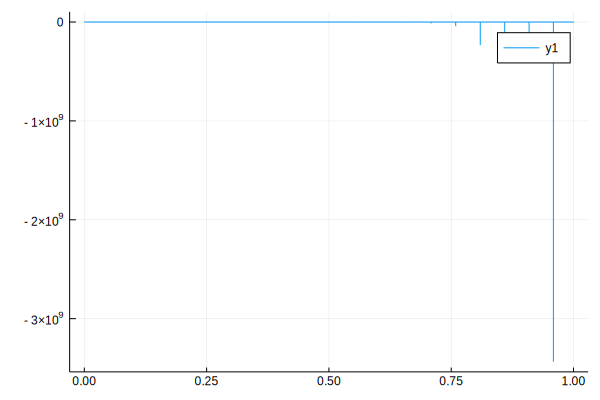

In [11]:
# plot(sol.t, sol[5,:])
ke1 = (0.5)*m1*((sol[7,:].*sol[7,:]) .+ (sol[10,:].*sol[10,:]))
ke2 = (0.5)*m2*((sol[8,:].*sol[8,:]) .+ (sol[11,:].*sol[11,:]))
ke3 = (0.5)*m3*((sol[9,:].*sol[9,:]) .+ (sol[12,:].*sol[12,:]))
ue1 = ((m1*m3) ./ ((   ((sol[1,:]-sol[3,:]).^2)+  ((sol[4,:]-sol[6,:]).^2)   ).^0.5)) + ((m1*m2) ./ ((   ((sol[1,:]-sol[2,:]).^2)+  ((sol[4,:]-sol[5,:]).^2)   ).^0.5))
ue2 = ((m2*m3) ./ ((   ((sol[2,:]-sol[3,:]).^2)+  ((sol[5,:]-sol[6,:]).^2)   ).^0.5)) + ((m3*m2) ./ ((   ((sol[2,:]-sol[3,:]).^2)+  ((sol[5,:]-sol[6,:]).^2)   ).^0.5))
ue3 = ((m1*m3) ./ ((   ((sol[1,:]-sol[3,:]).^2)+  ((sol[4,:]-sol[6,:]).^2)   ).^0.5)) + ((m3*m2) ./ ((   ((sol[2,:]-sol[3,:]).^2)+  ((sol[6,:]-sol[5,:]).^2)   ).^0.5))
ke = ke1 .+ ke2 .+ ke3
ue = -ue1 .- ue2 .- ue3
energy = (ke .+ ue) .- iEnergy

bary_X = (m1*sol[1,:]  .+ m2*sol[2,:] .+ m3*sol[3,:])/(m1+m2+m3)
bary_Y = (m1*sol[4,:]  .+ m2*sol[5,:] .+ m3*sol[6,:])/(m1+m2+m3)
plot(sol.t, energy)
# plot!(sol_a.t, bary_Y.-iBaryY)
# plot(sol3.t, bary_Y.-iBaryY)

In [ ]:
tEnd = []
tEnd = sol.t
deleteat!(tEnd,1)

eventID,m1a,m2a,m3a = [],[],[],[]
x1,x2,x3,y1,y2,y3 = [],[],[],[],[],[]
x1f,x2f,x3f,y1f,y2f,y3f = [],[],[],[],[],[]
dx1f,dx2f,dx3f,dy1f,dy2f,dy3f = [],[],[],[],[],[]

for (i,step) in enumerate(sol)
    if i == 1
        continue
    end

    append!(eventID, globalID+(i-1))
    append!(m1a, m1)
    append!(m2a, m2)
    append!(m3a, m3)

    append!(x1, p0[1])
    append!(x2, p0[2])
    append!(x3, p0[3])
    append!(y1, p0[4])
    append!(y2, p0[5])
    append!(y3, p0[6])

    append!(x1f, step[i][1])
    append!(x2f, step[i][2])
    append!(x3f, step[i][3])
    append!(y1f, step[i][4])
    append!(y2f, step[i][5])
    append!(y3f, step[i][6])

    append!(dx1f, step[i][7])
    append!(dx2f, step[i][8])
    append!(dx3f, step[i][9])
    append!(dy1f, step[i][10])
    append!(dy2f, step[i][11])
    append!(dy3f, step[i][12])

end

df = DataFrame(eventID=eventID, m1=m1a, m2=m2a, m3=m3a,
                x1=x1, x2=x2, x3=x3, y1=y1, y2=y2, y3=y3, tEnd=tEnd, 
                x1tEnd=x1f, x2tEnd=x2f, x3tEnd=x3f, y1tEnd=y1f, y2tEnd=y2f, y3tEnd=y3f,
                dx1tEnd=dx1f, dx2tEnd=dx2f, dx3tEnd=dx3f, dy1tEnd=dy1f, dy2tEnd=dy2f, dy3tEnd=dy3f)

# if i == 1
#     CSV.write(outputString, df; header=["eventID", "m1", "m2", "m3", "x1", "x2", "x3", "y1", "y2", "y3",
#                                         "tEnd", "x1tEnd", "x2tEnd", "x3tEnd", "y1tEnd", "y2tEnd", "y3tEnd",
#                                         "dx1tEnd", "dx2tEnd", "dx3tEnd", "dy1tEnd", "dy2tEnd", "dy3tEnd"] 
#                                         )
# #         types=[Int, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64,
# #                                             Float64, Float64, Float64, Float64,Float64, Float64,Float64, Float64,Float64, Float64, Float64, Float64, Float64, Float64]
# else
#     CSV.write(outputString, df; append=true)

# #         types=[Int, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64,
# #         Float64, Float64, Float64, Float64,Float64, Float64,Float64, Float64,Float64, Float64, Float64, Float64, Float64, Float64]
# end